closest for: 58330.3596906 is 20.640309399997932
shk: -0.33418209920658976
shk: 0.30535562470783006
shk: 0.2698536175689339
shk: -0.1430424608489446
closest for: 58330.3634695 is 20.636530499999935
shk: -0.7225552987874252
shk: -0.575517249660097
shk: 0.32004206958196973
shk: 0.2943288913528652
shk: 0.29414115645020483
shk: 0.23554655373200994
closest for: 58372.8929264 is 10.892926400003489
shk: 0.2570808955039555
closest for: 58372.8978241 is 10.897824100000435
shk: 0.2544821257850473
shk: 0.27253116165723396
shk: 0.2670848406280324
shk: 0.25719390841996254
shk: 0.25405679628287103
shk: 0.7535104553137211
shk: 1.0155709898318646
shk: 0.026061717376481604
shk: -0.027532815559423798
[[ 5.83303597e+04  5.84450094e+04  5.86381679e+04  5.85537528e+04
   5.83303635e+04  5.85537479e+04  5.84450143e+04  5.84978634e+04
   5.84978683e+04  5.86381728e+04  5.83728929e+04  5.83728978e+04
   5.83948319e+04  5.83948368e+04  5.84721245e+04  5.84721294e+04
   5.82724211e+04  5.82724249e+04  5.8354232

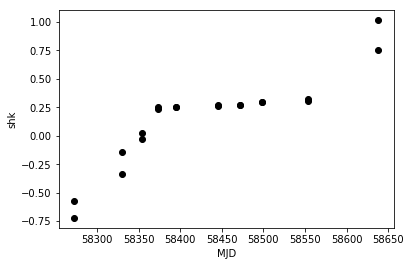

In [11]:
import scipy.io as sc
import astropy.io.fits
import numpy as np
import os
from calc_shk import calc_shk
from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)









idlfilepath = '/home/agoga/Documents/IotaH/Code/IDLPipeline/nres_shk/data/'
idlFlatFile = 'flat2.fits'
#idlFile = 'flat1.fits'
#TODO make path relative and OS indep
obsPath = '/home/agoga/Documents/nreshk/data/17051/obs/'
flatsPath = '/home/agoga/Documents/nreshk/data/17051/flats/'

fileNum = 0
dataFileList = ['cptnrs03-fa13-20190603-0031-e91.fits',
                'lscnrs01-fa09-20181219-0037-e91.fits',
                'cptnrs03-fa13-20190114-0032-e91.fits']
flatFileList= ['flat_cpt_nres03_fa13_20190603.fits',
                'flat_lsc_nres01_fa09_20181219.fits',
                'flat_cpt_nres03_fa13_20190114.fits']
varFileList = ['variables1.sav',
                'variables2.sav',
                'variables3.sav']

obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        obsDate = mjd_from_hdu(obsHDu1)
        obsDict.update({obsDate:obsHDu1})
#        print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

    
tmpArray = [[],[]]
for oK in obsDict:
    fK = closestKey(flatDict,oK)
    
    if abs(oK-fK) > 5:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    ret = mk_flatolap(oHDu[7].data, fHDu[0].data)
    
    shk = calc_shk(ret[0],oHDu[7].data,oHDu[1].data, ret[1],17.)
    tmpArray[0].append(mjd_from_hdu(obsDict[oK]))
    tmpArray[1].append(shk)


shkArray = np.asarray(tmpArray)
print(shkArray)
shkArray = np.sort(shkArray,1)
print(shkArray)
plt.figure()    
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.xlabel('MJD')
plt.ylabel('shk')
    
    
    
    
testObsFile = dataFileList[fileNum]
testFlatFile = flatFileList[fileNum]
idl = sc.readsav(idlfilepath+varFileList[fileNum])



testFlatHDu1 = astropy.io.fits.open(flatsPath+testFlatFile)
testObsHDu1 = astropy.io.fits.open(obsPath+testObsFile)

#print_header(testObsHDu1[0].header)

#print_header(flatHDu1[0].header)
#print(obsHDu1[0].header)
#hack the date out of flat file, better way I'm sure, split the end off then take last tertm after '_'
#TODO use MJD from fits header
#check dates btwn data/flat are at most ?a day? apart or warn
flatDate = testFlatHDu1[0].header['MJD-OBS']



ret = mk_flatolap(testObsHDu1[7].data, testFlatHDu1[0].data)
shk = calc_shk(ret[0],testObsHDu1[7].data,testObsHDu1[1].data, ret[1],17.)
print(shk)